# Predicting the Soil Temperature at 100cm depth using machine learning
### 1. Problem definition
> Soil temperature is one of the important parameters of a soil characteristics that contributes information in understanding the nitrate levels of a soil at different depths. This is because the soil temperature affects the soil's microbial activity, plant uptake, volatilization of Nitrogen compounds and leaching.  NMBU measure soil temperature at different depths (2cm, 5cm, 10cm, 20cm, 50cm, 100cm) using platinum resistance thermometers called PT100. Machine learning based predication may help reducing the effort and installation cost required to measure temperature at deeper soil levels such 100cm. This machine learning algorithm will first try to predict the soil temperature at 100cm from the different data features. 
### 2. Data Source
> To start the analysis process, the data source (2018-2022) is downloaded from the Meteorological data for Ås - BIOKLIM website (https://www.nmbu.no/forskning/grupper/meteorologiske-data) and organized into one big dataset which contains nearly 1800 samples. The improvements will be: first, the dataset will be improved to have bigger number of samples (2000-2024); second, multi-sites will be considererd to make the prediction more generic for different types of soils in Norway.
> #### There is one dataset inside the data folder
### 3. Evaluation metrics
> The evaluation metrics of R-squared (R²) Score, Mean Absolute Error (MAE), Mean Square Error (MSE) and Root Mean Square Log Error (RMSLE) will be considered as common regression metrics.
> > The goal of this machine learning model is to build a machine leanrning model that minimizes the erros: MAE, MSE, RMSLE and increase the R-squared (R²) Score.
### 4. Data Features
> The features of the dataset are:  month,	date, mean_air_temperature_2m, min_air_temperature_2m,	max_air_temperature_2m	soil_temperature_2cm,	soil_temperature_5cm,	soil_temperature_10cm,	soil_temperature_20cm,	soil_temperature_50cm,	relative_humudity_%,	air_pressure__2m_mbar,	radiation_balance_w_m2,	albedo_RR_GR,	earth_heat_flux_MJ_m2,	evaporation_mm,	rainfall_mm,	snowfall_cm.
>> The data is inside the data folder in this project.



In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [36]:
dataset = pd.read_csv("data/NMBUBigDatasetFinal.csv", low_memory=False)

In [37]:
dataset['snow_depth_cm'] = dataset['snow_depth_cm'].fillna(dataset['snow_depth_manual_cm'])
dataset.drop('snow_depth_manual_cm', axis=1, inplace=True)

In [38]:
# Add a date column by feature engineering
dataset['date'] = pd.to_datetime(dataset[['year', 'month', 'day']])
dataset_copied = dataset.copy()

In [39]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8856 entries, 0 to 8855
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   year                                 8856 non-null   int64         
 1   month                                8856 non-null   int64         
 2   day                                  8856 non-null   int64         
 3   mean_air_temperature_2m              8856 non-null   float64       
 4   min_air_temperature_2m               8856 non-null   float64       
 5   max_air_temperature_2m               8856 non-null   float64       
 6   relative_humidity                    8764 non-null   float64       
 7   air_pressure__2m_mbar                8822 non-null   float64       
 8   precipitation_mm                     8402 non-null   float64       
 9   evaporation_mm                       2466 non-null   float64       
 10  earth_heat_f

In [40]:
dataset.isna().sum()

year                                      0
month                                     0
day                                       0
mean_air_temperature_2m                   0
min_air_temperature_2m                    0
max_air_temperature_2m                    0
relative_humidity                        92
air_pressure__2m_mbar                    34
precipitation_mm                        454
evaporation_mm                         6390
earth_heat_flux_MJ_m2                   965
JT2                                      96
JT5                                      94
JT10                                    157
JT20                                    170
JT50                                    324
radiation_balance_w_m2                  202
phosynthetic_active_radiation_mE_m2     427
albedo_RR_GR                            684
snow_depth_cm                          7270
JT100                                    95
date                                      0
dtype: int64

### NOTE: There are huge missing values for evaporation_mm= 6392, snow_depth_cm=7272 which hugely affect our data if we randomly impute them. So we need to study why these data are missing or drop these features from our dataset. To see if the missing values are evenly distributed throughout the period or are missing at specific instants, let us see the time series trend.

#### Draw Evaporation(mm) vs Time to see the trend and missing values

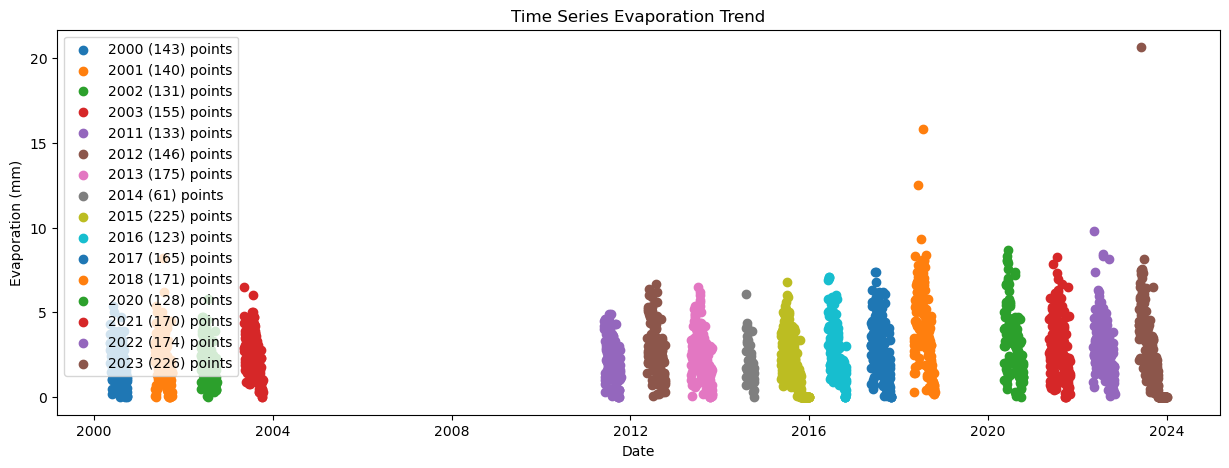

In [41]:
# Draw the scatter plot of the evaporation witht respect to time
# Filter out rows where evaporation is not missing
valid_evap_data = dataset_copied.dropna(subset=['evaporation_mm'])

# Group the valid data by year
# valid_evap_data['Year'] = valid_evap_data['year']
grouped_evap_data = valid_evap_data.groupby('year')

# Draw the scatter plot of snow_depth_cm vs date
fig, ax = plt.subplots(figsize=(15, 5))
for year, group in grouped_evap_data:
    ax.scatter(group['date'], group['evaporation_mm'], label=f'{year} ({len(group)}) points')

# Set plot title and labels
ax.set(title="Time Series Evaporation Trend", xlabel="Date", ylabel="Evaporation (mm)")

# Add legend
ax.legend()

plt.show()

### The above evaporation scatter plot shows there is missing data from 2004 - 2010 and 2019 which are in total 8 years. So, we can see at least 8 years data is fully missing. The daily evaporation value ranges from 0 to 20mm.

#### Draw Snow Depth(cm) vs Time to see the trend and missing values

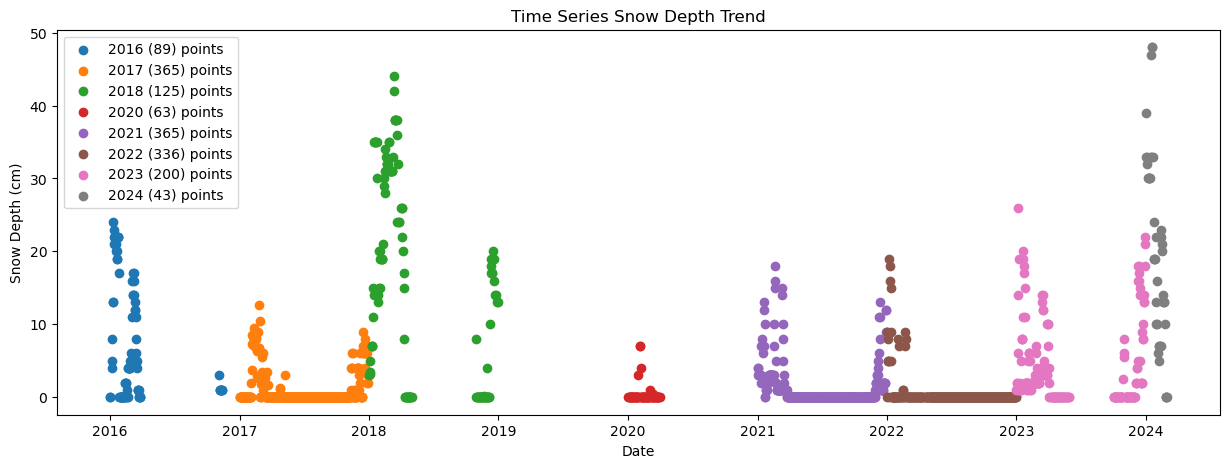

In [42]:
# Draw the scatter plot of the evaporation witht respect to time
# Filter out rows where snow_depth_cm is not missing
valid_snow_data = dataset_copied.dropna(subset=['snow_depth_cm'])

# Group the valid data by year
# valid_snow_data['Year'] = valid_snow_data['date'].dt.year
grouped_snow_data = valid_snow_data.groupby('year')

# Draw the scatter plot of snow_depth_cm vs date
fig, ax = plt.subplots(figsize=(15, 5))
for year, group in grouped_snow_data:
    ax.scatter(group['date'], group['snow_depth_cm'], label=f'{year} ({len(group)}) points')

# Set plot title and labels
ax.set(title="Time Series Snow Depth Trend", xlabel="Date", ylabel="Snow Depth (cm)")

# Add legend
ax.legend()

plt.show()

### The above snow depth scatter plot shows that snow data is completely missing from 2000-2015 and 2019. The daily snow depth ranges from 0 to about 50 cm.

### Let's fill the snow_depth_cm and evaporation_mm by the taking the average of the daily values for all the years to respective date's snow_depth and evaporation values if a specific day's is not NaN for all years otherwise fill by the average value of that specific month.

In [43]:
# Group by day and month and calculate the mean for snow_depth_cm and evaporation_mm
dataset_copied = dataset.copy()
mean_values = dataset_copied.groupby(['day', 'month']).agg({'snow_depth_cm': 'mean', 'evaporation_mm': 'mean'}).reset_index()

# Merge mean_values with the original DataFrame to fill missing values
dataset_copied = pd.merge(dataset_copied, mean_values, on=['day', 'month'], suffixes=('', '_mean'), how='left')

# Fill missing values with the mean values
dataset_copied['snow_depth_cm'] = dataset_copied['snow_depth_cm'].fillna(dataset_copied['snow_depth_cm_mean'])
dataset_copied['evaporation_mm'] = dataset_copied['evaporation_mm'].fillna(dataset_copied['evaporation_mm_mean'])

# Fill missing values for snow_depth_cm by monthly average
mean_snow_depth_cm_monthly = dataset_copied.groupby(['month'])['snow_depth_cm'].mean()
dataset_copied['snow_depth_cm'] = dataset_copied.apply(
    lambda row: mean_snow_depth_cm_monthly[row['month']] if pd.isna(row['snow_depth_cm']) else row['snow_depth_cm'],
    axis=1
)

# Fill missing values for evaporation_mm by monthly average
mean_evaporation_mm_monthly = dataset_copied.groupby(['month'])['evaporation_mm'].mean()
dataset_copied['evaporation_mm'] = dataset_copied.apply(
    lambda row: mean_evaporation_mm_monthly[row['month']] if pd.isna(row['evaporation_mm']) else row['evaporation_mm'],
    axis=1
)

# Drop auxiliary columns
dataset_copied.drop(['snow_depth_cm_mean', 'evaporation_mm_mean'], axis=1, inplace=True)

# Drop duplicates in case there are overlapping values from the merge
dataset_copied.drop_duplicates(inplace=True)

# Display the resulting DataFrame
dataset_copied

,year,month,day,mean_air_temperature_2m,min_air_temperature_2m,max_air_temperature_2m,relative_humidity,air_pressure__2m_mbar,precipitation_mm,evaporation_mm,...,JT5,JT10,JT20,JT50,radiation_balance_w_m2,phosynthetic_active_radiation_mE_m2,albedo_RR_GR,snow_depth_cm,JT100,date
0,2000,1,1,-4.958,-7.620,-3.021,100.000,1001.536,NaN,NaN,...,-0.090,0.058,0.443,1.872,-0.122,1.171,0.739,0.800000,3.427,2000-01-01
1,2000,1,2,0.649,-4.951,4.009,88.578,997.675,NaN,NaN,...,-0.074,0.041,0.448,1.873,-2.208,1.618,0.767,7.000000,3.406,2000-01-02
2,2000,1,3,2.129,-1.130,4.588,88.588,991.451,8.800,NaN,...,-0.057,0.039,0.450,1.873,-1.796,0.707,0.390,7.214286,3.391,2000-01-03
3,2000,1,4,1.762,-3.258,4.390,67.333,986.959,2.100,NaN,...,-0.030,0.082,0.468,1.917,-4.827,2.487,0.478,7.700000,3.393,2000-01-04
4,2000,1,5,0.557,-3.631,4.385,98.227,993.310,1.200,NaN,...,-0.023,0.104,0.475,1.922,-0.442,1.675,0.169,8.500000,3.361,2000-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8851,2024,3,28,5.222,2.426,7.898,90.027,976.682,7.594,NaN,...,1.316,1.008,0.944,1.236,0.448,0.213,-0.121,0.750000,1.986,2024-03-28
8852,2024,3,29,5.930,4.711,7.385,93.565,978.338,2.573,NaN,...,2.577,2.134,1.735,1.510,0.286,0.180,3.692,2.500000,2.053,2024-03-29
8853,2024,3,30,5.908,3.958,7.362,94.385,990.109,1.980,NaN,...,3.302,2.837,2.454,1.949,0.611,0.181,0.952,2.000000,2.180,2024-03-30
8854,2024,3,31,6.167,2.384,8.020,93.633,988.136,2.903,NaN,...,4.050,3.616,3.135,2.404,0.015,0.176,-0.917,2.000000,2.343,2024-03-31


In [44]:
dataset_copied.isna().sum()

year                                      0
month                                     0
day                                       0
mean_air_temperature_2m                   0
min_air_temperature_2m                    0
max_air_temperature_2m                    0
relative_humidity                        92
air_pressure__2m_mbar                    34
precipitation_mm                        454
evaporation_mm                         2976
earth_heat_flux_MJ_m2                   965
JT2                                      96
JT5                                      94
JT10                                    157
JT20                                    170
JT50                                    324
radiation_balance_w_m2                  202
phosynthetic_active_radiation_mE_m2     427
albedo_RR_GR                            684
snow_depth_cm                             0
JT100                                    95
date                                      0
dtype: int64

In [45]:
### Drop the unnecessary columns

In [46]:
# Drop the unnecessary columns
# dropped_coulms = ["year","month","day","mean_wind_speed_10m_m_s", "max_wind_speed_10_m_s","wind_direction_10m"]
# dataset_copied.drop(columns=dropped_coulms, axis=1, inplace=True)
# Fill or disregard missing values

dataset_copied["evaporation_mm"] = dataset_copied["evaporation_mm"].fillna(0.0)
dataset_copied["JT2"] = dataset_copied["JT2"].fillna(dataset_copied["JT2"].mean())
dataset_copied["JT5"] = dataset_copied["JT5"].fillna(dataset_copied["JT5"].mean())
dataset_copied["JT10"] = dataset_copied["JT10"].fillna(dataset_copied["JT10"].mean())
dataset_copied["JT20"] = dataset_copied["JT20"].fillna(dataset_copied["JT20"].mean())
dataset_copied["JT50"] = dataset_copied["JT50"].fillna(dataset_copied["JT50"].mean())
dataset_copied["JT100"] = dataset_copied["JT100"].fillna(dataset_copied["JT100"].mean())
dataset_copied["relative_humidity"] = dataset_copied["relative_humidity"].fillna(dataset_copied["relative_humidity"].mean())
dataset_copied["air_pressure__2m_mbar"] = dataset_copied["air_pressure__2m_mbar"].fillna(dataset_copied["air_pressure__2m_mbar"].mean())
dataset_copied["radiation_balance_w_m2"] = dataset_copied["radiation_balance_w_m2"].fillna(dataset_copied["radiation_balance_w_m2"].mean())
dataset_copied["albedo_RR_GR"] = dataset_copied["albedo_RR_GR"].fillna(dataset_copied["albedo_RR_GR"].mean())
dataset_copied["earth_heat_flux_MJ_m2"] = dataset_copied["earth_heat_flux_MJ_m2"].fillna(dataset_copied["earth_heat_flux_MJ_m2"].mean())
dataset_copied["precipitation_mm"] = dataset_copied["precipitation_mm"].fillna(dataset_copied["precipitation_mm"].mean())
dataset_copied["snow_depth_cm"] = dataset_copied["snow_depth_cm"].fillna(0.0)

### Soil temperature at 100cm with respect to time

KeyError: 'target_soil_temperature_100cm'

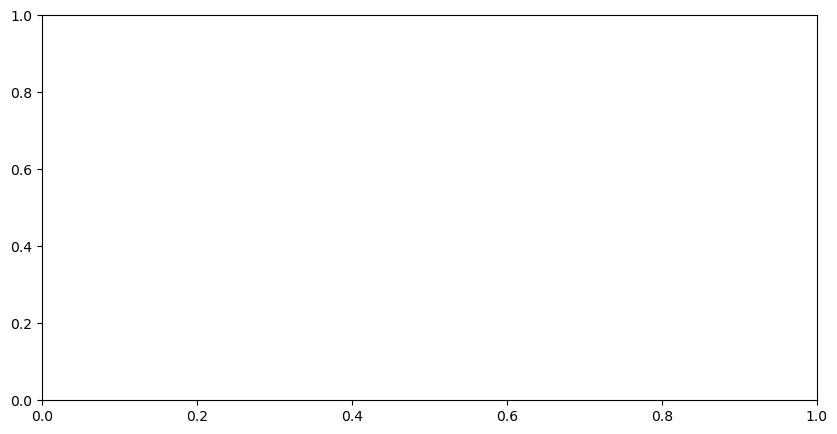

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(dataset["date"][:1000], dataset["target_soil_temperature_100cm"][:1000]);
ax.scatter(dataset["date"][1000:], dataset["target_soil_temperature_100cm"][1000:]);
ax.set(title="Time Series Soil Temperature @ 100cm depth", xlabel="Date", ylabel="Soil Temp(celsius)");

In [ ]:
fig, ax = plt.subplots(figsize =(10,5))
ax.hist(dataset["target_soil_temperature_100cm"]);
ax.set(title="Soil Temperature (100cm) Histogram", xlabel='Soil Temp (celsius)', ylabel="Frequency");

### Plot the different features with respect to target label = soil temperature at 100cm

In [ ]:
columns_index = dataset_copied.columns
cols_array = columns_index.values
# Create a figure and axis array with 4 rows and 3 columns
fig, axs = plt.subplots(4, 3, figsize=(15, 10))  # Adjust figsize as needed

# Flatten the axis array for easier iteration
axs = axs.flatten()
length = len(dataset_copied)-1

# Plot data on each subplot
for i, ax in enumerate(axs):
    # Plot your data on each subplot
    ax.plot(dataset_copied["target_soil_temperature_100cm"][:length], dataset_copied[cols_array[i]][:length])  # Example data, replace with your data
    ax.set_title(f'Soil Temperature (100cm) vs {cols_array[i]}')  # Set subplot title
    ax.set_xlabel('Soil Temp 100cm (celsius)')  # Set x-axis label
    ax.set_ylabel(f'{cols_array[i]}')  # Set y-axis label

plt.tight_layout()  # Adjust subplot layout
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # For enhanced plotting capabilities

# Scatter Plot
def scatter_plot(ax, x, y, xlabel, ylabel, title):
    ax.scatter(x, y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

# Line Plot
def line_plot(ax, x, y, xlabel, ylabel, title):
    ax.plot(x, y)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

# Box Plot
def box_plot(ax, data, xlabel, ylabel, title):
    ax.boxplot(data)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

# Pair Plot
def pair_plot(data):
    sns.pairplot(data)

# Joint Plot
def joint_plot(ax, x, y, xlabel, ylabel, title):
    sns.jointplot(x=x, y=y, kind="scatter", ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

# Define histogram plot function if not defined previously
def histogram_plot(ax, data, title):
    ax.hist(data, bins=20)
    ax.set_title(title)

# Create a sample dataset
np.random.seed(10)

fig, axs = plt.subplots(4, 3, figsize=(15, 10))  # Adjust figsize as needed

# Flatten the axis array for easier iteration
axs = axs.flatten()
length = len(dataset_copied)-1

# Plot data on each subplot
for i, ax in enumerate(axs):
    # Get the column name from cols_array
    col_name = cols_array[i] if i < len(cols_array) else None
    
    if col_name:
        # Scatter Plot
        scatter_plot(ax, dataset_copied["target_soil_temperature_100cm"][:length], dataset_copied[col_name][:length], "X", "Y", f"Scatter Plot {col_name}")
        ax.set_title(f'Soil Temperature (100cm) vs {col_name}')  # Set subplot title
        ax.set_xlabel('Soil Temp 100cm (celsius)')  # Set x-axis label
        ax.set_ylabel(f'{col_name}')  # Set y-axis label

        # Joint Plot
        joint_plot(ax, dataset_copied["target_soil_temperature_100cm"][:length], dataset_copied[col_name][:length], "X", "Y", f"Line Plot {col_name}")
        ax.set_title(f'Soil Temperature (100cm) vs {col_name}')  # Set subplot title
        ax.set_xlabel('Soil Temp 100cm (celsius)')  # Set x-axis label
        ax.set_ylabel(f'{col_name}')  # Set y-axis label
        
        # Box Plot
        box_plot(ax, dataset_copied[col_name][:length], "X", "Y", f"Histogram {col_name}")
        ax.set_title(f'Soil Temperature (100cm) vs {col_name}')  # Set subplot title
        ax.set_xlabel('Soil Temp 100cm (celsius)')  # Set x-axis label
        ax.set_ylabel(f'{col_name}')  # Set y-axis label
       
    else:
        # Remove any extra subplot
        ax.axis('off')

plt.tight_layout()
plt.show()

